## Ergast Formula 1 Database

Ноутбук, посвященный гонкам Формулы-1. 

Основная его цель:
 - просто вспомнить SQL;
 - вспомнить оконные функции;
 - вспомнить, как подключаться к локальной базе;
 - вспомнить, как визуализировать "сухие" таблицы SQL средствами python.

### Загрузка библиотек


In [5]:
import pymysql
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Решение проблем с подключением локальной базы к VSCode

Подключаемся к локальной базе. Работаем через VSCode. В процессе фиксим ошибку *ER_NOT_SUPPORTED_AUTH_MODE Client*.

#### Windows

- Вызываем cmd в папке bin MySQL (C:\Program Files\MySQL\MySQL Server 8.3\bin) 
- CREATE USER '**sqluser**'@'%' IDENTIFIED WITH mysql_native_password BY '**password**'; 
- GRANT ALL PRIVILEGES ON *.* TO 'sqluser'@'%'; 
- FLUSH PRIVILEGES;

#### Linux

- sudo mysql -u root -p
- ALTER USER "root"@"localhost" identified with mysql_native_password by "pass";

### Подключение к локальной базе

In [7]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="rt",
                       password="__________",
                       database="sys",
                       charset="utf8")


sql = """
SELECT * 
  FROM circuits;
"""

df = pd.read_sql(sql, conn)
df.head(5)

C:\Temp\ipykernel_8676\3983184444.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


Вроде работает. 

### Работа с запросами

*1. Вывести количество треков по странам*

In [ ]:
sql1 = """
SELECT country, COUNT(location) AS 'Количество'   
  FROM circuits
 GROUP by country
 ORDER BY 2 DESC;
 """

df = pd.read_sql(sql1, conn)
df.head(10)

C:\Temp\ipykernel_8676\1506444159.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql1, conn)


,country,Количество
0,USA,11
1,France,7
2,Spain,6
3,Italy,4
4,Portugal,4
5,UK,4
6,Japan,3
7,Belgium,3
8,Canada,3
9,Germany,3


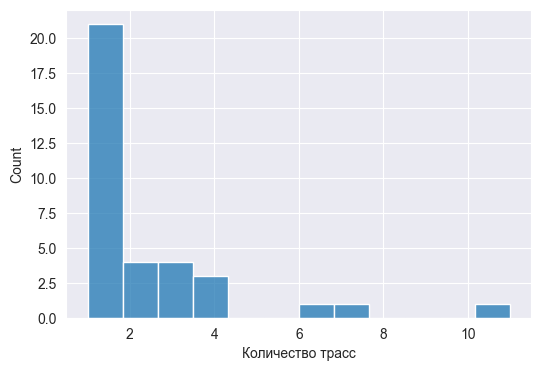

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(6,4))
x = df['Количество']
x = pd.Series(x, name="Количество трасс")
ax = sns.histplot(x, bins=12)
plt.show()

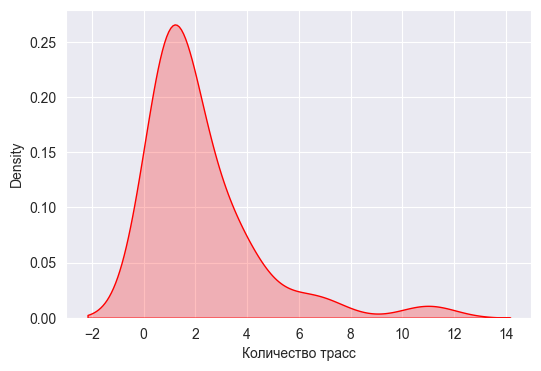

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(6,4))
x = df['Количество']
x = pd.Series(x, name="Количество трасс")
ax = sns.kdeplot(x, fill= True, color='r')
plt.show()

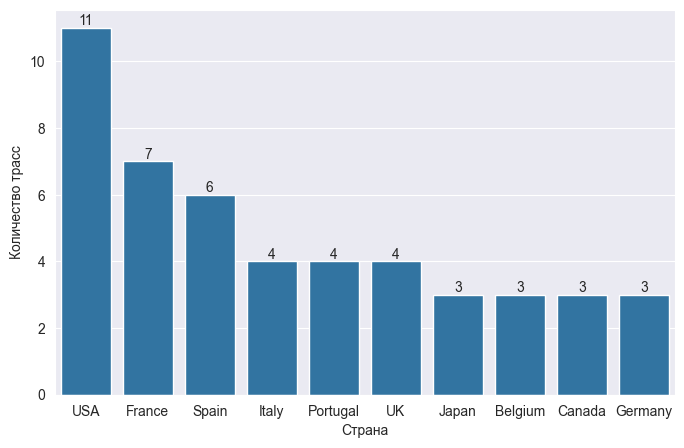

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=df, x=df.country[:10], y="Количество")
ax.set_xlabel('Страна', fontdict={'size': 10})
ax.set_ylabel('Количество трасс', fontdict={'size': 10})
ax.bar_label(ax.containers[0])
# for i in ax.containers:
#     ax.bar_label(i,)
plt.show()

*2. Вывести кубок конструкторов за 20-23 годы. Сортировка по убыванию.*

In [ ]:
sql2 = """
SELECT con.name AS "Команда", 
       SUM(rc.points) AS "Очки", 
       r.year 
  FROM results rc
       INNER JOIN constructors con USING (constructorId)
             JOIN races r USING (raceId)
 WHERE r.YEAR >= 2018
 GROUP BY 1,3
 ORDER BY 3, 2 DESC;
"""

df2 = pd.read_sql(sql2, conn)
df2.head(10)

C:\Temp\ipykernel_1904\4290888719.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(sql2, conn)


,Команда,Очки,year
0,Mercedes,655.0,2018
1,Ferrari,571.0,2018
2,Red Bull,419.0,2018
3,Renault,122.0,2018
4,Force India,111.0,2018
5,Haas F1 Team,93.0,2018
6,McLaren,62.0,2018
7,Sauber,48.0,2018
8,Toro Rosso,33.0,2018
9,Williams,7.0,2018


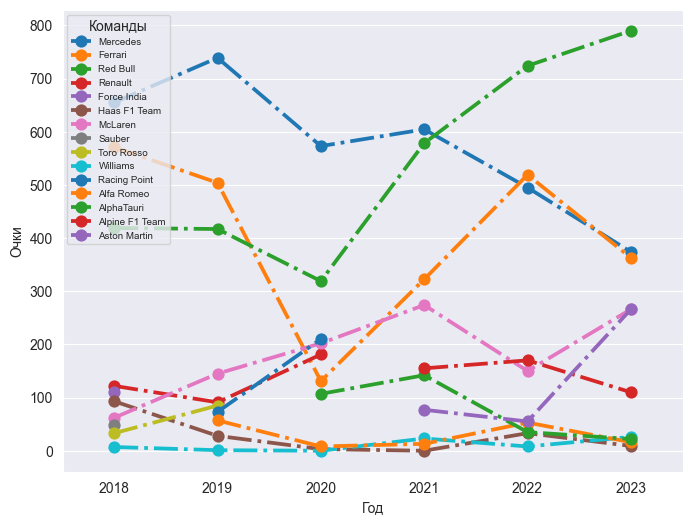

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x="year",
              y="Очки", 
              linestyles = '-.',
              hue="Команда",
              data=df2,
              palette="tab10")
ax.set_xlabel('Год', fontdict={'size': 10})
ax.set_ylabel('Очки', fontdict={'size': 10})
plt.legend(title = 'Команды', fontsize="7", loc ="upper left")
plt.show()

*3. Вывести гонщиков с наибольшим количеством побед. Сортировка по убыванию. Вывод ограничить 20 пилотами*

In [ ]:
sql3 = """
SELECT CONCAT(d.forename,' ',d.surname) AS "Pilot", COUNT(r.YEAR) AS "Количество побед"
  FROM results rc
   		INNER JOIN drivers d USING (driverId)
   		      JOIN races r USING (raceId)
 WHERE r.YEAR >= 1950 AND rc.position = 1
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 20;
"""

df3 = pd.read_sql(sql3, conn)
df3.head(10)

C:\Temp\ipykernel_1904\2143894786.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(sql3, conn)


,Pilot,Количество побед
0,Lewis Hamilton,103
1,Michael Schumacher,91
2,Max Verstappen,54
3,Sebastian Vettel,53
4,Alain Prost,51
5,Ayrton Senna,41
6,Fernando Alonso,32
7,Nigel Mansell,31
8,Jackie Stewart,27
9,Jim Clark,25


*4. Вывести гонщиков Ferrari, выступавших за конюшню с 1996 по 2023 годы, и посчитать их набранные очки. Присвоить им ранг.*

In [ ]:
sql4 = """
SELECT DENSE_RANK() OVER (ORDER BY SUM(r.points) DESC) AS 'Rank',
	   CONCAT(d.forename,' ',d.surname) AS 'Пилот',
  	   SUM(r.points) AS 'Очки'
  FROM drivers d
       INNER JOIN results r USING (driverId)
       	     JOIN constructors cons USING (constructorId)
       	     JOIN races USING (raceId)
 WHERE cons.name = 'Ferrari' 
   AND races.YEAR >= 1996 
   AND races.YEAR < 2024
 GROUP BY 2
 ORDER BY 1;
"""

df4 = pd.read_sql(sql4, conn)
df4.head(10)

C:\Temp\ipykernel_1904\2963395708.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = pd.read_sql(sql4, conn)


,Rank,Пилот,Очки
0,1,Sebastian Vettel,1400.0
1,2,Fernando Alonso,1190.0
2,3,Kimi Räikkönen,1080.0
3,4,Michael Schumacher,1066.0
4,5,Charles Leclerc,997.0
5,6,Felipe Massa,789.0
6,7,Carlos Sainz,569.5
7,8,Rubens Barrichello,412.0
8,9,Eddie Irvine,156.0
9,10,Mika Salo,10.0


*5.Вывести гонщиков Mclaren, выступавших за конюшню с 1990 по 2023 годы, и посчитать их победы и набранные очки за эту команду.*

In [ ]:
sql5 = """
WITH cte AS(   
SELECT CONCAT(d.forename,' ', d.surname) AS "Пилот",
       driverid,
       SUM(res.position) AS "Победы"
  FROM results res
       INNER JOIN drivers d USING (driverId)
			 JOIN constructors cons USING (constructorId)
			 JOIN races USING (raceId)
 WHERE cons.name = 'McLaren'
   AND races.YEAR >= 1990
   AND races.YEAR < 2024
   AND res.position = '1'
 GROUP BY 1,2
 )
          
 SELECT Пилот,
        Победы,
        SUM(results.points) AS "Очки"
   FROM cte
        INNER JOIN results USING (driverId)
              JOIN constructors cons USING (constructorId)
  WHERE cons.name = 'McLaren'
  GROUP BY 1,2
  ORDER BY 3 DESC;
  """

df5 = pd.read_sql(sql5, conn)
df5.head(10)

C:\Temp\ipykernel_1904\1702859064.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = pd.read_sql(sql5, conn)


,Пилот,Победы,Очки
0,Lewis Hamilton,21.0,913.0
1,Jenson Button,8.0,908.0
2,Ayrton Senna,21.0,451.0
3,David Coulthard,12.0,412.0
4,Mika Häkkinen,20.0,407.0
5,Kimi Räikkönen,9.0,337.0
6,Fernando Alonso,4.0,241.0
7,Daniel Ricciardo,1.0,148.0
8,Gerhard Berger,3.0,135.0
9,Juan Pablo Montoya,3.0,86.0


*6.Вывести 15 лучших кругов на СПА. Присвоить ранги. (res rank)*

In [ ]:
sql6 = """
SELECT DENSE_RANK() OVER (ORDER BY milliseconds ASC) AS 'Rank',
       r.YEAR AS 'Год',
 	   c.name AS 'Трасса', 
 	   time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f') AS 'Время круга, в мс'
  FROM lapTimes l
	   INNER JOIN races r USING (raceId)
             JOIN circuits c USING (circuitId)
 WHERE c.name = 'Circuit de Spa-Francorchamps'
   AND milliseconds IN (
                        SELECT min(milliseconds)
                          FROM lapTimes l2
                               INNER JOIN races r2 USING (raceId)
                                     JOIN circuits c2 USING (circuitId)
                         WHERE c2.name = 'Circuit de Spa-Francorchamps'
                         GROUP BY r2.YEAR, r2.raceId, c2.name
                         )
 LIMIT 15;
 """

df6 = pd.read_sql(sql6, conn)
df6.head(15)

C:\Temp\ipykernel_1904\2435548389.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df6 = pd.read_sql(sql6, conn)


,Rank,Год,Трасса,"Время круга, в мс"
0,1,2004,Circuit de Spa-Francorchamps,01:45:108000
1,2,2018,Circuit de Spa-Francorchamps,01:46:286000
2,3,2019,Circuit de Spa-Francorchamps,01:46:409000
3,4,2017,Circuit de Spa-Francorchamps,01:46:577000
4,5,2002,Circuit de Spa-Francorchamps,01:47:176000
5,6,2009,Circuit de Spa-Francorchamps,01:47:263000
6,7,2023,Circuit de Spa-Francorchamps,01:47:305000
7,8,2020,Circuit de Spa-Francorchamps,01:47:483000
8,9,2008,Circuit de Spa-Francorchamps,01:47:930000
9,10,2007,Circuit de Spa-Francorchamps,01:48:036000


In [ ]:
sql = """
WITH cte AS(
SELECT l2.lap, 
       r2.YEAR,
       c2.name,
       time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f') AS "foll_time",
       LAG(time_format(SEC_TO_TIME(milliseconds/1000), '%i:%s:%f'), 1) OVER (ORDER BY l2.lap) AS "prev_time",
       milliseconds - LAG(milliseconds, 1) OVER (ORDER BY l2.lap) AS "diff",
       ROUND(AVG(milliseconds) OVER (ORDER BY l2.lap
       								  ROWS BETWEEN 1 PRECEDING 
       								  AND 2 FOLLOWING)) AS "roll_avg"
  FROM laptimes l2
       INNER JOIN races r2 USING (raceId)
       		 JOIN circuits c2 USING (circuitId)
             JOIN drivers d USING (driverId)
  WHERE c2.name = 'Albert Park Grand Prix Circuit'
    AND d.surname = 'Schumacher' 
    AND d.forename = 'Michael'
    AND r2.YEAR = 2004
ORDER BY 1 ASC
)

SELECT cte.lap, cte.name, foll_time, prev_time,
	time_format(SEC_TO_TIME(diff/1000), '%i:%s:%f') AS "Разница",
	time_format(SEC_TO_TIME(roll_avg/1000), '%i:%s:%f') AS "Скользящее"
	FROM cte;
"""
import pandas as pd
df = pd.read_sql(sql, conn)
df

C:\Temp\ipykernel_10572\3317183971.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


,lap,name,foll_time,prev_time,Разница,Скользящее
0,1,Albert Park Grand Prix Circuit,01:33:122000,None,None,01:27:999000
1,2,Albert Park Grand Prix Circuit,01:25:906000,01:33:122000,-00:07:216000,01:27:127000
2,3,Albert Park Grand Prix Circuit,01:24:968000,01:25:906000,-00:00:938000,01:25:047000
3,4,Albert Park Grand Prix Circuit,01:24:513000,01:24:968000,-00:00:455000,01:24:697000
4,5,Albert Park Grand Prix Circuit,01:24:802000,01:24:513000,00:00:289000,01:24:589000
5,6,Albert Park Grand Prix Circuit,01:24:506000,01:24:802000,-00:00:296000,01:24:503000
6,7,Albert Park Grand Prix Circuit,01:24:533000,01:24:506000,00:00:027000,01:24:385000
7,8,Albert Park Grand Prix Circuit,01:24:170000,01:24:533000,-00:00:363000,01:24:342000
8,9,Albert Park Grand Prix Circuit,01:24:330000,01:24:170000,00:00:160000,01:24:291000
9,10,Albert Park Grand Prix Circuit,01:24:334000,01:24:330000,00:00:004000,01:29:600000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lap         58 non-null     int64 
 1   name        58 non-null     object
 2   foll_time   58 non-null     object
 3   prev_time   57 non-null     object
 4   Разница     57 non-null     object
 5   Скользящее  58 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.8+ KB


In [ ]:
df['Скользящее'] = pd.to_datetime(df['Скользящее'], format='%M:%S:%f')

In [ ]:
df['Скользящее'] =df['Скользящее'].dt.strftime('%M:%S:%f')

In [ ]:
df.head(5)

,lap,name,foll_time,prev_time,Разница,Скользящее
0,1,Albert Park Grand Prix Circuit,01:33:122000,None,None,01:27:999000
1,2,Albert Park Grand Prix Circuit,01:25:906000,01:33:122000,-00:07:216000,01:27:127000
2,3,Albert Park Grand Prix Circuit,01:24:968000,01:25:906000,-00:00:938000,01:25:047000
3,4,Albert Park Grand Prix Circuit,01:24:513000,01:24:968000,-00:00:455000,01:24:697000
4,5,Albert Park Grand Prix Circuit,01:24:802000,01:24:513000,00:00:289000,01:24:589000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='lap', ylabel='Скользящее'>

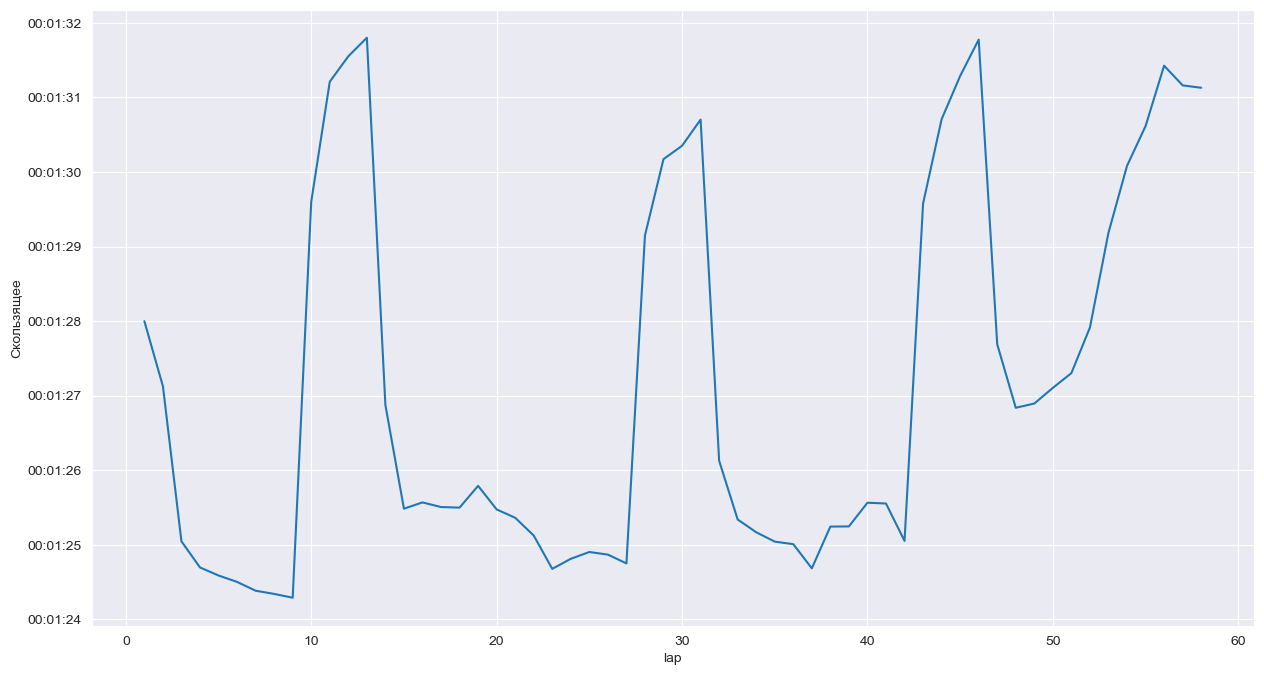

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 8))
sns.lineplot(x=df["lap"], y=df["Скользящее"], data=df)

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(modelfit_2, 0, 250, ax=ax)
    plt.plot(temper, color='red', label='Series')
    plt.legend()
    plt.show()